In [3]:
pip install lightfm

     |████████████████████████████████| 310 kB 6.9 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705372 sha256=a05201b8a03cddd73a5d73dc11dfa1cfeb8e0d355027319b9120f96ea7044695
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [4]:
from lightfm.data import Dataset
import json
from itertools import islice
import pandas as pd
import numpy as np
from lightfm import LightFM
from scipy.sparse import coo_matrix
import os
from google.colab import drive
#if run on local machine, set your path here
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/Big_Data_Final_Project

Mounted at /content/drive
/content/drive/MyDrive/Big_Data_Final_Project


In [5]:
#if run on colab, set your path here
#path = "/content/drive/MyDrive/Big_Data_Final_Project/Data"

In [6]:
files = os.listdir(path)

In [7]:
files[4]

'train_small'

In [8]:
val_medium = pd.read_csv(f"{path}/{files[2]}", header = None)
test_medium = pd.read_csv(f"{path}/{files[1]}", header = None)
test_small = pd.read_csv(f"{path}/{files[3]}", header = None)
val_small =pd.read_csv(f"{path}/{files[5]}", header = None) 

In [9]:
train_path1 = "/content/drive/MyDrive/Big_Data_Final_Project/Data/train_small"
train_path2 = "/content/drive/MyDrive/Big_Data_Final_Project/Data/train_medium"
#train_path3


In [10]:
def read_file(path, columns_name):
  df = pd.DataFrame()
  for file in os.listdir(path):
    df = df.append(pd.read_csv(f"{path}/{file}", header = None))

  df.columns = columns_name
  return df

In [11]:
train_small = read_file(train_path1,['userId', 'movieId', 'rating', 'tag', 'timestamp', 'title', 'genre', 'imbdid', 'tmdbid'])
train_medium = read_file(train_path2,['userId', 'movieId', 'rating'])

In [12]:
val_medium.columns = ['userId', 'movieId', 'rating']
test_medium.columns = ['userId', 'movieId', 'rating']



In [13]:
val_small.columns = ['userId', 'movieId', 'rating', 'tag', 'timestamp', 'title', 'genre', 'imbdid', 'tmdbid']
test_small.columns = ['userId', 'movieId', 'rating', 'tag', 'timestamp', 'title', 'genre', 'imbdid', 'tmdbid']
val_small = val_small[['userId', 'movieId', 'rating']]
test_small = test_small[['userId', 'movieId', 'rating']]
train_small = train_small[['userId', 'movieId', 'rating']]

In [14]:
movies = train_small.movieId.unique()
movies_v = val_small.movieId.unique()
movies_test = test_small.movieId.unique()
len = 0
for j in movies_v:
  if j not in movies:
     val_small = val_small[val_small['movieId'] != j]

for j in movies_test:
  if j not in movies:
     test_small = test_small[test_small['movieId'] != j]


In [15]:
df_merge = pd.merge(val_small, train_small, on=['userId','movieId','rating'], how='inner')
val_small = val_small.append(df_merge) 

val_small['Duplicated'] = val_small.duplicated(keep=False) # keep=False marks the duplicated row with a True
val_final = val_small[~val_small['Duplicated']] # selects only rows which are not duplicated.
del val_final['Duplicated'] # delete the indicator column



In [16]:
df_merge_1 = pd.merge(test_small, train_small, on=['userId','movieId','rating'], how='inner')
test_small = test_small.append(df_merge_1) 

test_small['Duplicated'] = test_small.duplicated(keep=False) # keep=False marks the duplicated row with a True
test_final = test_small[~test_small['Duplicated']] # selects only rows which are not duplicated.
del test_final['Duplicated'] # delete the indicator column

In [17]:
val_final.reset_index(drop=True, inplace=True)


In [18]:
test_final.reset_index(drop=True, inplace=True)

In [19]:
model_small = Dataset()
model_small.fit((i for i in train_small['userId'].unique()),(j for j in train_small['movieId'].unique()))
tr_interaction, w = model_small.build_interactions((((r[1]['userId'], r[1]['movieId'], r[1]['rating']) for r in train_small.iterrows())))


In [20]:
def map_val_interaction(val, model):
  user_map, item_map = model.mapping()[0], model.mapping()[2]
  user_id = np.array([user_map[k] for k in val.userId])
  item_id = np.array([item_map[i] for i in val.movieId])
  rating = val['rating']
  transformed_matrix = coo_matrix((rating, (user_id, item_id)), shape = model.interactions_shape())
  return transformed_matrix


In [21]:
small_val = map_val_interaction(val_final, model_small)

In [22]:
small_test = map_val_interaction(test_final, model_small)

Construct a Sparse Matrix which row are user id, and column are movieID

In [23]:
from lightfm.evaluation import precision_at_k

In [84]:
from time import time
iter = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,55,60, 65, 70, 75,80, 85, 90]
reg = 0.001
r = 10
result = []
t = []

for i in iter:
  init = time()
  m = LightFM(no_components= r, user_alpha = reg, loss='warp', random_state = 1999)
  m.fit(interactions = tr_interaction, sample_weight = w, epochs = i)
  pred = precision_at_k(m, small_val, train_interactions=tr_interaction, k=100).mean()
  total = time() - init
  t.append(total)
  result.append(pred)

  print('when max iteration is {}, reg_para is {}, and rank is {}'.format(i, reg, r))
  print("running time is {}".format(total))
  print('the Precision at 100 is {}'.format(pred))


when max iteration is 5, reg_para is 0.001, and rank is 10
running time is 0.547889232635498
the Precision at 100 is 0.2121538668870926
when max iteration is 10, reg_para is 0.001, and rank is 10
running time is 0.8997585773468018
the Precision at 100 is 0.22676922380924225
when max iteration is 15, reg_para is 0.001, and rank is 10
running time is 1.2055790424346924
the Precision at 100 is 0.23161539435386658
when max iteration is 20, reg_para is 0.001, and rank is 10
running time is 1.5420689582824707
the Precision at 100 is 0.2322307527065277
when max iteration is 25, reg_para is 0.001, and rank is 10
running time is 1.856114387512207
the Precision at 100 is 0.23461538553237915
when max iteration is 30, reg_para is 0.001, and rank is 10
running time is 2.2291247844696045
the Precision at 100 is 0.235846146941185
when max iteration is 35, reg_para is 0.001, and rank is 10
running time is 2.5383245944976807
the Precision at 100 is 0.23723077774047852
when max iteration is 40, reg_para

Text(0.5, 1.0, 'Rank = 10 and reg_para = 0.001, on mini(1%) dataset')

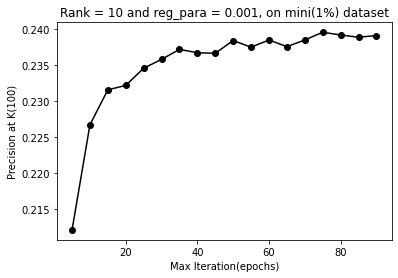

In [85]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.plot(iter, result, color = 'k',linestyle='-', marker='o', label = 'loss = warp', mec = 'k', mfc = 'k')
ax.set_xlabel('Max Iteration(epochs)')
ax.set_ylabel('Precision at K(100)')
ax.set_title("Rank = 10 and reg_para = 0.001, on mini(1%) dataset")

In [81]:
from time import time
iter = 25
reg_para = [0.0001, 0.0005, 0.001,0.005, 0.01, 0.05, 0.1, 0.5]
r = 10
result1 = []
t1 = []
for reg in reg_para:
  init = time()
  m = LightFM(no_components= r, user_alpha = reg, loss='warp', random_state = 1999)
  m.fit(interactions = tr_interaction, sample_weight = w, epochs = iter)
  pred = precision_at_k(m, small_val, train_interactions=tr_interaction, k=100).mean()
  total = time() - init
  t1.append(total)
  result1.append(pred)
  print('when max iteration is {}, reg_para is {}, and rank is {}'.format(iter, reg, r))
  print("running time is {}".format(total))
  print('the Precision at 100 is {}'.format(pred))

when max iteration is 25, reg_para is 0.0001, and rank is 10
running time is 1.9393393993377686
the Precision at 100 is 0.2337692230939865
when max iteration is 25, reg_para is 0.0005, and rank is 10
running time is 1.9213991165161133
the Precision at 100 is 0.2330000102519989
when max iteration is 25, reg_para is 0.001, and rank is 10
running time is 1.948345422744751
the Precision at 100 is 0.23461538553237915
when max iteration is 25, reg_para is 0.005, and rank is 10
running time is 1.961200475692749
the Precision at 100 is 0.21592307090759277
when max iteration is 25, reg_para is 0.01, and rank is 10
running time is 1.9270153045654297
the Precision at 100 is 0.18038462102413177
when max iteration is 25, reg_para is 0.05, and rank is 10
running time is 1.985023021697998
the Precision at 100 is 0.0023846153635531664
when max iteration is 25, reg_para is 0.1, and rank is 10
running time is 1.9725368022918701
the Precision at 100 is 0.006923076696693897
when max iteration is 25, reg_p

In [80]:
from time import time
iter = 25
reg = 0.001
rank = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
result2 = []
t2 = []
for r in rank:
  init = time()
  m = LightFM(no_components= r, user_alpha = reg, loss='warp', random_state = 1999)
  m.fit(interactions = tr_interaction, sample_weight = w, epochs = iter)
  pred = precision_at_k(m, small_val, train_interactions=tr_interaction, k=100).mean()
  total = time() - init
  t2.append(total)
  result2.append(pred)
  print('when max iteration is {}, reg_para is {}, and rank is {}'.format(iter, reg, r))
  print("running time is {}".format(total))
  print('the Precision at 100 is {}'.format(pred))

when max iteration is 25, reg_para is 0.001, and rank is 10
running time is 2.0005738735198975
the Precision at 100 is 0.23461538553237915
when max iteration is 25, reg_para is 0.001, and rank is 20
running time is 2.8812949657440186
the Precision at 100 is 0.23646153509616852
when max iteration is 25, reg_para is 0.001, and rank is 30
running time is 3.659104347229004
the Precision at 100 is 0.24015383422374725
when max iteration is 25, reg_para is 0.001, and rank is 40
running time is 8.900588989257812
the Precision at 100 is 0.24146151542663574
when max iteration is 25, reg_para is 0.001, and rank is 50
running time is 5.393122673034668
the Precision at 100 is 0.2400769293308258
when max iteration is 25, reg_para is 0.001, and rank is 60
running time is 6.766097068786621
the Precision at 100 is 0.23715385794639587
when max iteration is 25, reg_para is 0.001, and rank is 70
running time is 7.149378776550293
the Precision at 100 is 0.23592309653759003
when max iteration is 25, reg_par

Text(0.5, 1.0, 'LightFM Max Iteration = 25, rank = 10')

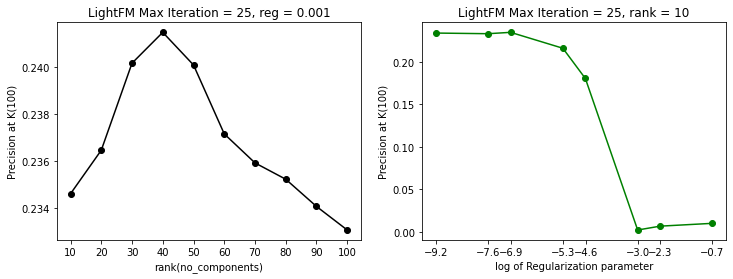

In [82]:
import matplotlib.pyplot as plt
fig, ((ax1, ax2))  = plt.subplots(1,2,figsize=(12,4))

ax1.plot(rank, result2, color = 'k',linestyle='-', marker='o', label = 'regParam = 0.001', mec = 'k', mfc = 'k')
ax2.plot(np.log(reg_para), result1, color = 'g',linestyle='-', marker='o', label = 'rank = 10', mec = 'g', mfc = 'g')
ax1.set_xlabel('rank(no_components)')
ax1.set_ylabel('Precision at K(100)')
ax1.set_xticks(rank)
ax1.set_title("LightFM Max Iteration = 25, reg = 0.001")
ax2.set_xlabel('log of Regularization parameter')
ax2.set_ylabel('Precision at K(100)')
ax2.set_xticks([round(i, 1) for i in np.log(reg_para)])
ax2.set_title("LightFM Max Iteration = 25, rank = 10")

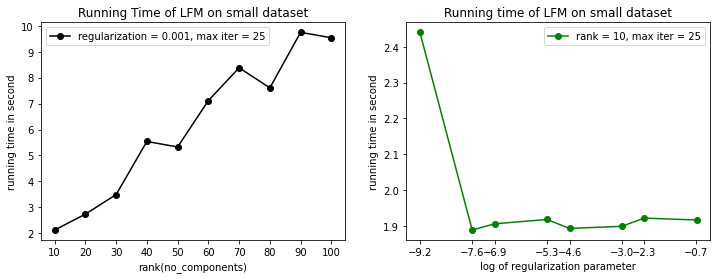

In [69]:
fig, ((ax1, ax2))  = plt.subplots(1,2,figsize=(12,4))

ax1.plot(rank, t2, color = 'k',linestyle='-', marker='o', label = 'regularization = 0.001, max iter = 25', mec = 'k', mfc = 'k')
ax2.plot(np.log(reg_para), t1, color = 'g',linestyle='-', marker='o', label = 'rank = 10, max iter = 25', mec = 'g', mfc = 'g')
ax1.set_xlabel('rank(no_components)')
ax1.set_ylabel('running time in second')
ax1.set_xticks(rank)
ax1.set_title("Running Time of LFM on small dataset")
ax2.set_xlabel('log of regularization parameter')
ax2.set_ylabel('running time in second')
ax2.set_xticks([round(i, 1) for i in np.log(reg_para)])
ax2.set_title("Running time of LFM on small dataset")
ax1.legend()
ax2.legend()


Prediction on the test set

In [78]:

init = time()
m = LightFM(no_components= 10, user_alpha = 0.001, loss='warp', random_state = 1999)
m.fit(interactions = tr_interaction, sample_weight = w, epochs = 25)
pred = precision_at_k(m, small_test, train_interactions=tr_interaction, k=100).mean()
total = time() - init
print(pred)
print(total)



0.21460177
2.1128406524658203
